<a href="https://colab.research.google.com/github/PetrGavrilin/VKR_URFU/blob/main/VKR_part5_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Нейронная сеть</h1>

In [ ]:
# Загрузка необходимых библиотек и функций

import sys
sys.path.append('/content')

from vkr_function import my_features_extraction, print_scores, plot_predict, my_test_train_split, my_test_val_train_split

import os

import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential #Сеть прямого распространения
#Базовые слои для свёрточных сетей
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D,  Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam # оптимизатор

try:
  from plot_keras_history import show_history, plot_history
except:
  !pip install plot_keras_history
  from plot_keras_history import show_history, plot_history


In [ ]:
# Загрузка данных
Y_ = pd.read_csv('/content/flow_rate.csv')
sig_up = pd.read_csv('/content/sig_up.csv')
sig_dw = pd.read_csv('/content/sig_dw.csv')
borders = pd.read_csv('/content/borders.csv').values.tolist()[0]

In [ ]:
from scipy.signal import savgol_filter
sig_up_sg = sig_up.apply(lambda x: savgol_filter(x,30,4), axis=0) # сглаженные сигналы 1-го пьезоэлектрического датчика
sig_dw_sg = sig_dw.apply(lambda x: savgol_filter(x,30,4), axis=0) # сглаженные сигналы 2-го пьезоэлектрического датчика

In [ ]:
#scaler = preprocessing.MinMaxScaler()

#sig_up = scaler.fit_transform(sig_up)
#sig_dw = scaler.fit_transform(sig_dw)

In [ ]:
X = []

for i_x in range(sig_up.shape[0]):
  #X_ = [sig_up.iloc[i_x,:], sig_dw.iloc[i_x,:]]
  X_ = [sig_up_sg.iloc[i_x,:], sig_dw_sg.iloc[i_x,:]]
  X_ = list(map(list, zip(*X_)))
  X.append(X_)

X = np.array(X)
X.shape

(3915, 512, 2)

In [ ]:
# Разделение на выборки

Y = np.array(Y_['Et'])
input_dim = X.shape[1]

X_train, y_train, i_train, X_val, y_val, i_val, X_test, y_test, i_test =  my_test_val_train_split(X, Y, borders)

In [ ]:
# изменение формата данных
X_train = tf.convert_to_tensor(X_train, np.float32)
X_test = tf.convert_to_tensor(X_test, np.float32)
X_val = tf.convert_to_tensor(X_val, np.float32)
y_train = tf.convert_to_tensor(y_train, np.float32)
y_val = tf.convert_to_tensor(y_val, np.float32)
y_test = tf.convert_to_tensor(y_test, np.float32)

In [ ]:
# Свёрточная нейронная сеть

activation_function = 'tanh'
filter_amount = 64
kz=2

model = Sequential()
model.add(BatchNormalization(input_shape=(512, 2)))
#Первый сверточный слой
model.add(Conv1D(128, 2, padding='same', activation=activation_function))
model.add(Conv1D(128, 2, padding='same', activation=activation_function))
model.add(MaxPooling1D(pool_size=2, strides=2))
#model.add(Dropout(0.01))
#Второй сверточный слой
model.add(Conv1D(128, 2, padding='same', activation=activation_function))
model.add(Conv1D(128, 2, padding='same', activation=activation_function))
model.add(MaxPooling1D(pool_size=2, strides=2))
#Слой регуляризации Dropout
#model.add(Dropout(0.01))
#Третий сверточный слой
model.add(Conv1D(128, 2, padding='same', activation=activation_function))
model.add(Conv1D(128, 2, padding='same', activation=activation_function))
model.add(MaxPooling1D(pool_size=2, strides=2))
#Слой регуляризации Dropout
model.add(Dropout(0.05))
model.add(Flatten())
#Полносвязный слой для классификации
model.add(Dense(256, activation='relu6'))
#model.add(Dropout(0.5))
#Выходной полносвязный слой
model.add(Dense(1, activation='relu6'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_3 (Bat  (None, 512, 2)            8         
 chNormalization)                                                
                                                                 
 conv1d_18 (Conv1D)          (None, 512, 128)          640       
                                                                 
 conv1d_19 (Conv1D)          (None, 512, 128)          32896     
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 256, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_20 (Conv1D)          (None, 256, 128)          32896     
                                                                 
 conv1d_21 (Conv1D)          (None, 256, 128)         

In [ ]:
opt = keras.optimizers.Adam(
    learning_rate=0.00001
) # оптимизатор

model.save_weights('model.h5') # сохранение весов

# компиляция модели
model.compile(
    optimizer=opt,
    loss='mean_squared_error',
    metrics=[keras.metrics.RootMeanSquaredError(), keras.metrics.R2Score()]
    )

In [ ]:
# сброс лучшей модели
try:
    os.remove("/content/Checkpoint_path.keras")
except OSError:
    pass

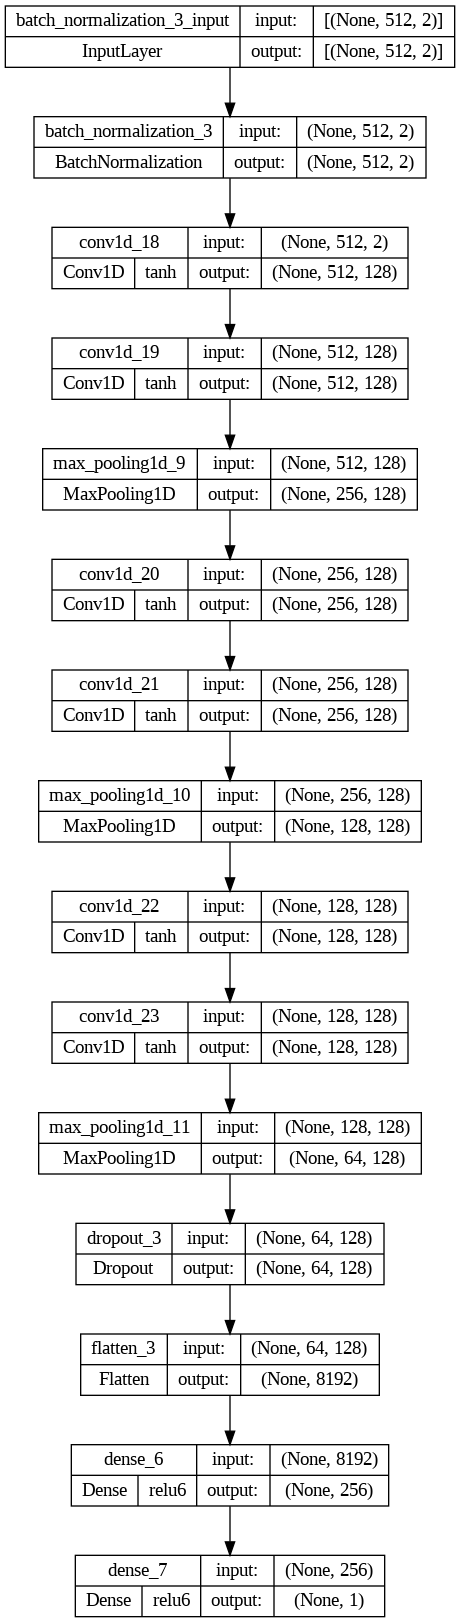

In [ ]:
# вывод струтуры модели
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_activations=True,
    )

In [ ]:
# класс обратного вызова
callback_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=16,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="Checkpoint_path.keras",
        nonitor="val_loss",
        save_best_only=True,
    )
]

In [ ]:
# Обучение модели
history = model.fit(
    X_train, y_train, epochs=64, batch_size=64,
    callbacks=callback_list, validation_data=(X_val, y_val)
    )

Epoch 1/64
40/40 [==============================] - 25s 549ms/step - loss: 0.7945 - root_mean_squared_error: 0.8914 - r2_score: -0.5356 - val_loss: 1.0592 - val_root_mean_squared_error: 1.0292 - val_r2_score: -1.0504
Epoch 2/64
40/40 [==============================] - 22s 559ms/step - loss: 0.0468 - root_mean_squared_error: 0.2163 - r2_score: 0.9096 - val_loss: 0.3316 - val_root_mean_squared_error: 0.5758 - val_r2_score: 0.3582
Epoch 3/64
40/40 [==============================] - 22s 539ms/step - loss: 0.0110 - root_mean_squared_error: 0.1048 - r2_score: 0.9788 - val_loss: 0.0934 - val_root_mean_squared_error: 0.3055 - val_r2_score: 0.8193
Epoch 4/64
40/40 [==============================] - 21s 519ms/step - loss: 0.0078 - root_mean_squared_error: 0.0882 - r2_score: 0.9850 - val_loss: 0.0386 - val_root_mean_squared_error: 0.1965 - val_r2_score: 0.9252
Epoch 5/64
40/40 [==============================] - 24s 601ms/step - loss: 0.0057 - root_mean_squared_error: 0.0755 - r2_score: 0.9890 - v

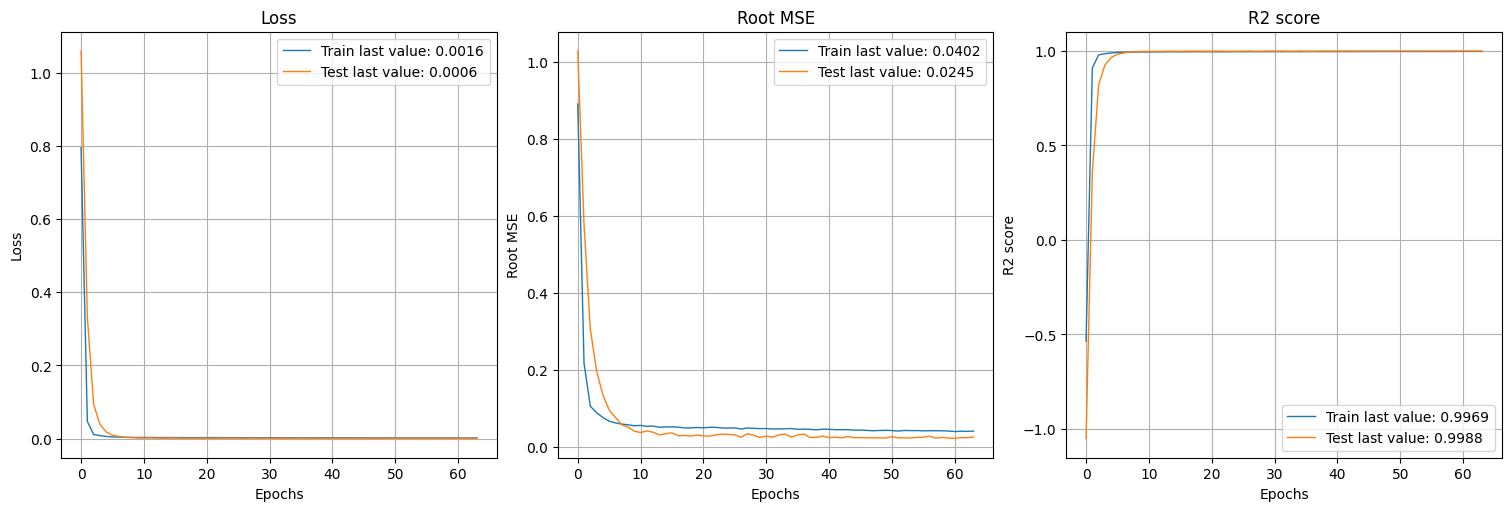

In [ ]:
# вывод графиков с изменением метрик
show_history(history)
plot_history(history, path="standard.png")
plt.close()

In [ ]:
# предсказание модели на тестовых данных
y_predict = model.predict(X_test)

20/20 [==============================] - 1s 59ms/step


In [ ]:
# вывод метрик
print("Тестовая выборка:")
model.evaluate(X_test,y_test)
print("Валидационная выборка:")
model.evaluate(X_val,y_val)
print("Тренировочная выборка:")
model.evaluate(X_train,y_train)
pass

Тестовая выборка:
20/20 [==============================] - 1s 66ms/step - loss: 5.1255e-04 - root_mean_squared_error: 0.0226 - r2_score: 0.9990
Валидационная выборка:
25/25 [==============================] - 2s 64ms/step - loss: 6.0224e-04 - root_mean_squared_error: 0.0245 - r2_score: 0.9988
Тренировочная выборка:
79/79 [==============================] - 6s 79ms/step - loss: 5.1396e-04 - root_mean_squared_error: 0.0227 - r2_score: 0.9990


In [ ]:
# предсказание модели на полных данных
#X = X.reshape(X.shape[0], 2, 512,1)
y_predict_all = model.predict(X)
print_scores(Y, y_predict_all, False)

123/123 [==============================] - 9s 74ms/step
Ошибка на полных данных
MSE: 0.00053
RMSE: 0.02305
R2 : 0.99897


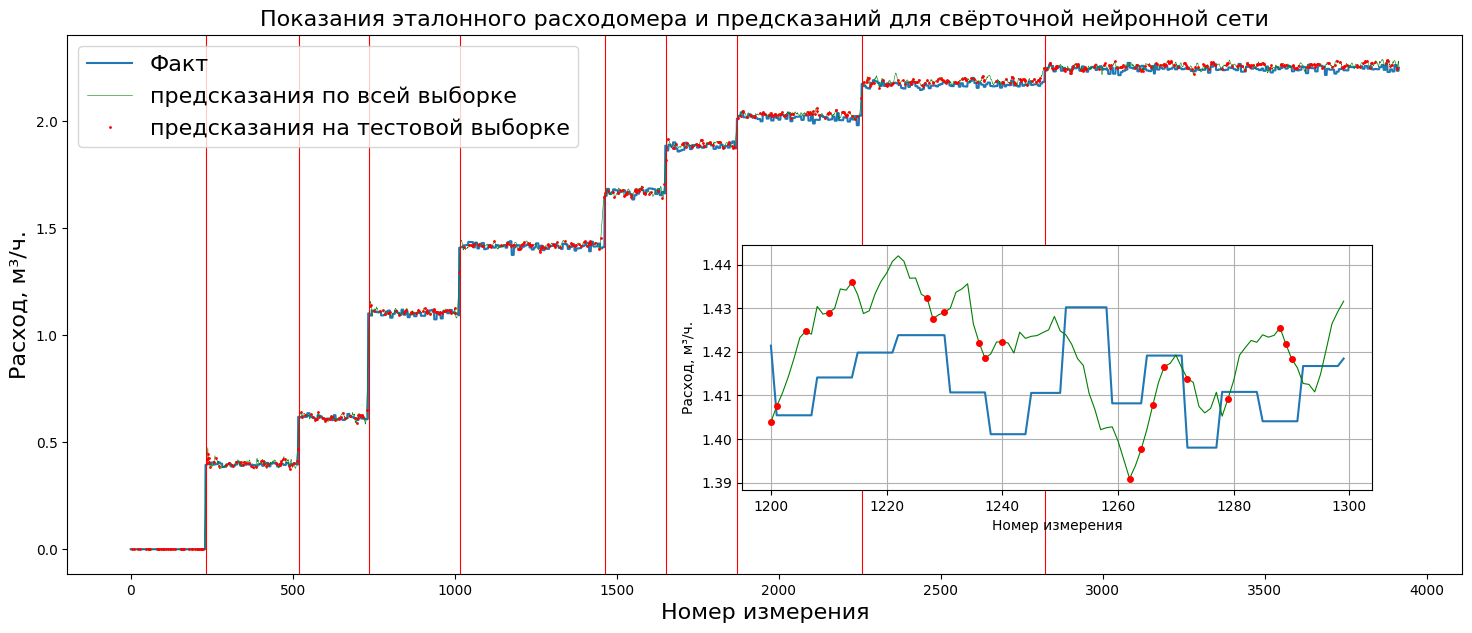

In [ ]:
# Вывод графика с фактическими и предсказанными данными
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="свёрточной нейронной сети")

In [ ]:
# Загружаем лучшую модель
best_model = keras.models.load_model("/content/Checkpoint_path.keras")

In [ ]:
# вывод метрик
print("Тестовая выборка:")
best_model.evaluate(X_test,y_test)
print("Валидационная выборка:")
best_model.evaluate(X_val,y_val)
print("Тренировочная выборка:")
best_model.evaluate(X_train,y_train)
pass

Тестовая выборка:
20/20 [==============================] - 2s 62ms/step - loss: 3.6328e-04 - root_mean_squared_error: 0.0191 - r2_score: 0.9993
Валидационная выборка:
25/25 [==============================] - 2s 60ms/step - loss: 4.5159e-04 - root_mean_squared_error: 0.0213 - r2_score: 0.9991
Тренировочная выборка:
79/79 [==============================] - 6s 78ms/step - loss: 3.8375e-04 - root_mean_squared_error: 0.0196 - r2_score: 0.9993


In [ ]:
# предсказание модели на тестовых данных
y_predict = best_model.predict(X_test)

20/20 [==============================] - 1s 60ms/step


In [ ]:
# предсказание модели на полных данных
y_predict_all = best_model.predict(X)

123/123 [==============================] - 9s 73ms/step


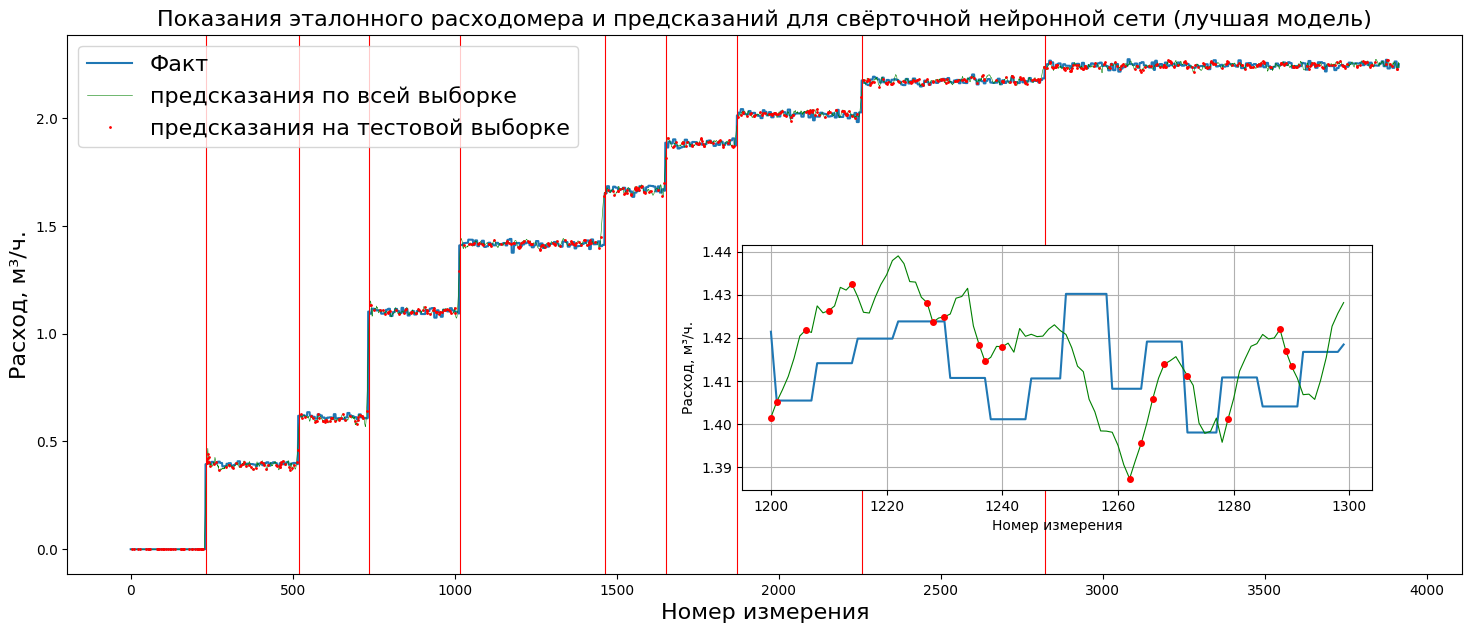

In [ ]:
# Вывод графика с фактическими и предсказанными данными
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="свёрточной нейронной сети (лучшая модель)")

<h2>Проверим работу модели, приняв за тестовую выборку один из режимов расхода</h2>

In [ ]:
# Новое разделение на тестовую, валидационную и обучающую выборки

l_ = len(Y)

_, _, _, _, i_val = my_test_train_split(X, Y, borders, test_size=0.2)

i_test = list(range(borders[3],borders[4]))

i_train = list(range(0,l_))
for x1 in i_test:
  i_train.remove(x1)
for x2 in i_val:
  try:
    i_train.remove(x2)
  except:
    i_ = 0

for x3 in i_test:
  try:
    i_val.remove(x3)
  except:
    i_ = 0

X_train = X[i_train,:,:]
y_train = Y[i_train]

X_val = X[i_val,:,:]
y_val = Y[i_val]

X_test = X[i_test,:,:]
y_test = Y[i_test]


In [ ]:
# сброс весов модели
model.load_weights('model.h5')

In [ ]:
# сброс лучшей модели
try:
    os.remove("/content/Checkpoint_path.keras")
except OSError:
    print("removing is failed")

In [ ]:
# Обучение модели
history = model.fit(
    X_train, y_train, epochs=64, batch_size=64,
    callbacks=callback_list, validation_data=(X_val, y_val)
    )

Epoch 1/64
44/44 [==============================] - 24s 544ms/step - loss: 0.3769 - root_mean_squared_error: 0.6139 - r2_score: 0.3475 - val_loss: 0.4131 - val_root_mean_squared_error: 0.6427 - val_r2_score: 0.2844
Epoch 2/64
44/44 [==============================] - 23s 535ms/step - loss: 0.0069 - root_mean_squared_error: 0.0833 - r2_score: 0.9880 - val_loss: 0.1061 - val_root_mean_squared_error: 0.3257 - val_r2_score: 0.8162
Epoch 3/64
44/44 [==============================] - 22s 504ms/step - loss: 0.0029 - root_mean_squared_error: 0.0537 - r2_score: 0.9950 - val_loss: 0.0429 - val_root_mean_squared_error: 0.2071 - val_r2_score: 0.9257
Epoch 4/64
44/44 [==============================] - 25s 562ms/step - loss: 0.0021 - root_mean_squared_error: 0.0457 - r2_score: 0.9964 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1142 - val_r2_score: 0.9774
Epoch 5/64
44/44 [==============================] - 25s 577ms/step - loss: 0.0018 - root_mean_squared_error: 0.0427 - r2_score: 0.9968 - val

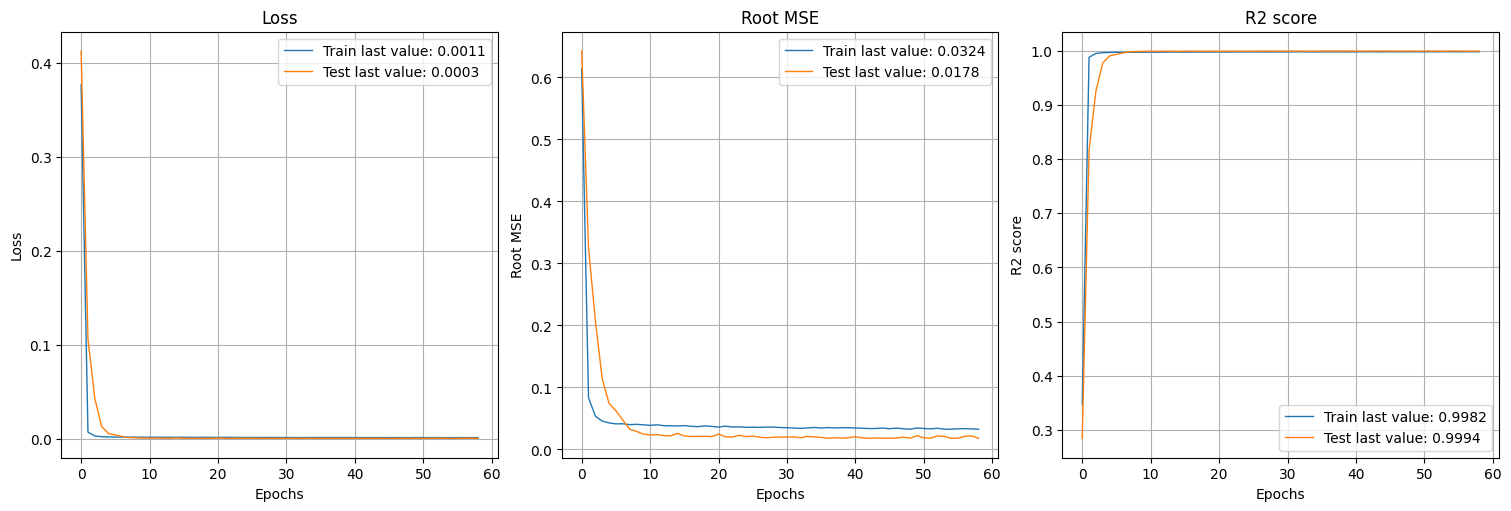

In [ ]:
# вывод графиков с изменением метрик
show_history(history)
plot_history(history, path="standard.png")
plt.close()

In [ ]:
# предсказание модели на тестовых данных
y_predict = model.predict(X_test)

15/15 [==============================] - 1s 63ms/step


In [ ]:
# вывод метрик
print("Тестовая выборка:")
model.evaluate(X_test,y_test)
print("Валидационная выборка:")
model.evaluate(X_val,y_val)
print("Тренировочная выборка:")
model.evaluate(X_train,y_train)
pass

Тестовая выборка:
15/15 [==============================] - 1s 66ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415 - r2_score: -5.6424
Валидационная выборка:
22/22 [==============================] - 2s 67ms/step - loss: 3.1823e-04 - root_mean_squared_error: 0.0178 - r2_score: 0.9994
Тренировочная выборка:
87/87 [==============================] - 7s 79ms/step - loss: 3.0652e-04 - root_mean_squared_error: 0.0175 - r2_score: 0.9995


In [ ]:
# предсказание модели на полных данных
y_predict_all = model.predict(X)
print_scores(Y, y_predict_all, False)

123/123 [==============================] - 9s 75ms/step
Ошибка на полных данных
MSE: 0.00047
RMSE: 0.02171
R2 : 0.99909


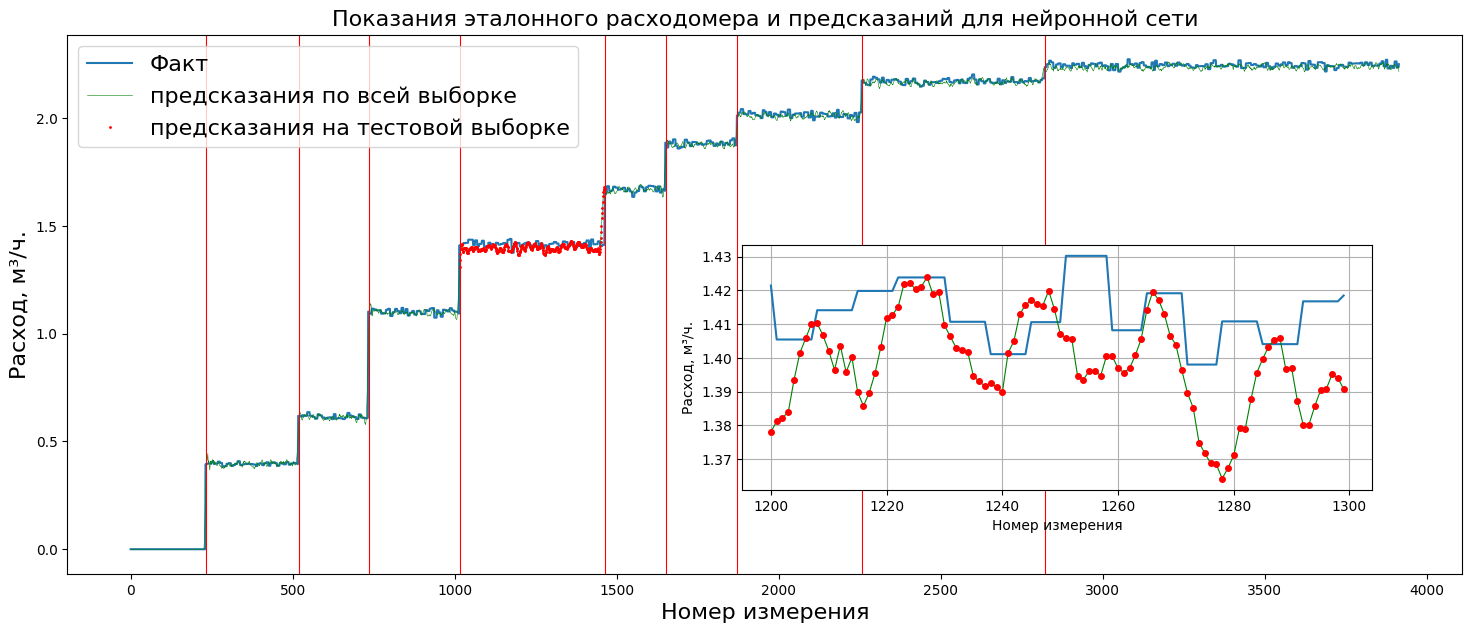

In [ ]:
# Вывод графика с фактическими и предсказанными данными
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="нейронной сети")

In [ ]:
best_model = keras.models.load_model("/content/Checkpoint_path.keras")

In [ ]:
# вывод метрик
print("Тестовая выборка:")
best_model.evaluate(X_test,y_test)
print("Валидационная выборка:")
best_model.evaluate(X_val,y_val)
print("Тренировочная выборка:")
best_model.evaluate(X_train,y_train)
pass

Тестовая выборка:
15/15 [==============================] - 1s 58ms/step - loss: 0.0016 - root_mean_squared_error: 0.0402 - r2_score: -5.2203
Валидационная выборка:
22/22 [==============================] - 1s 60ms/step - loss: 3.1793e-04 - root_mean_squared_error: 0.0178 - r2_score: 0.9994
Тренировочная выборка:
87/87 [==============================] - 7s 78ms/step - loss: 3.0016e-04 - root_mean_squared_error: 0.0173 - r2_score: 0.9995


In [ ]:
# предсказание модели на тестовых данных
y_predict = best_model.predict(X_test)

15/15 [==============================] - 1s 58ms/step


In [ ]:
# предсказание модели на полных данных
y_predict_all = best_model.predict(X)

123/123 [==============================] - 9s 74ms/step


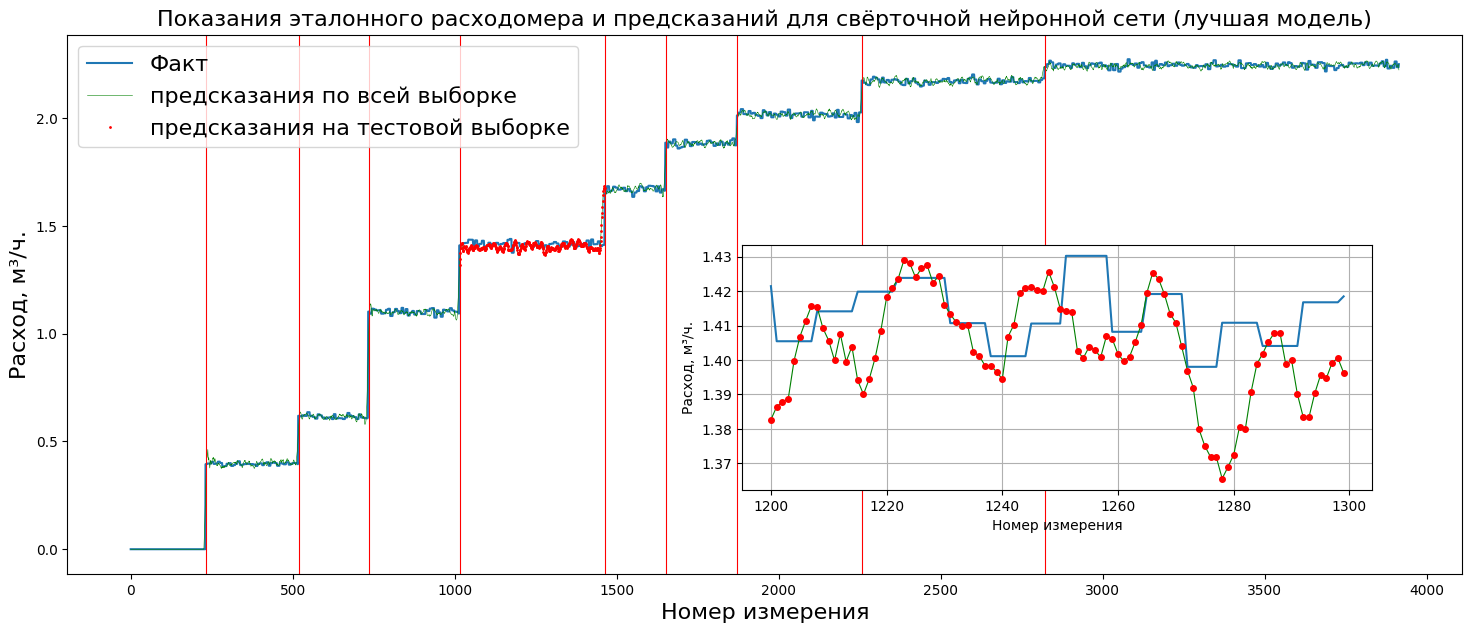

In [ ]:
# Вывод графика с фактическими и предсказанными данными
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="свёрточной нейронной сети (лучшая модель)")

In [ ]:
#del[model]